# Data Analysis

Here I work on loading the data for processing

In [91]:
# Importing libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import lecroy
import os
import sys
from scipy.fft import rfft, irfft, rfftfreq

In [151]:
def fs(t, t0):
    f = 9*1e6 # Hz
    gamma = f/2*np.pi
    return np.sqrt(gamma)*np.exp(-gamma*np.abs(t-t0))

In [152]:
# Load data
data_folder = 'C:\\Users\\tbrav\\OneDrive\\Skrivebord\\data-tora' # Path to data folder
#dates = os.listdir(data_folder)
dates = ['091027']
datasets = ['cat2']

def get_file_list(date, dataset):
    folder = os.path.join(data_folder, date, dataset)
    fns = sorted(os.listdir(folder))
    fns = [os.path.join(folder, fn) for fn in fns]
    return fns

files = {dat:{ds:get_file_list(dat, ds) for ds in datasets} for dat in dates}
#files

In [153]:
meta, times, data = lecroy.read(files[dates[0]]['cat2'][0], scale=False)
dt = meta['horiz_interval']
#fs = 1/dt
N = len(data[0])
t = np.linspace(0, dt*N, N, endpoint=False)
#f = rfftfreq(N, dt)
#meta

In [154]:
for ds in datasets:
    data = np.array([[
        lecroy.read(f, scale=False)[2] for f in files[dat][ds]]
                     for dat in dates])
    data = data.squeeze()
    globals()[ds] = data


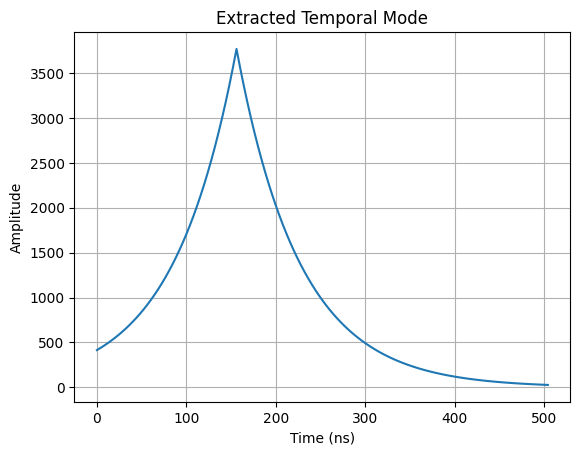

In [156]:
# Extract vacuum data
vacuum = data[36]
# Calculate mean and standard deviation for calibration
vacuum_mean = np.mean(vacuum)
vacuum_std = np.std(vacuum)
vacuum_var = vacuum.var(axis=0)

# Define temporal mode from peak in variance
temporal_mode = fs(t, t[39])  # shape (T,)
temporal_mode /= np.sqrt(np.sum(temporal_mode**2) * dt)

#temporal_mode /= np.linalg.norm(temporal_mode)

plt.plot(t*1e9, temporal_mode)
plt.title("Extracted Temporal Mode")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Calculate mean and standard deviation for calibration
vacuum_mean = np.mean(vacuum)
vacuum_std = np.std(vacuum)

In [157]:
vacuum_std

np.float64(14.010484133403649)

Index: 0, Angle: 0 deg
Index: 3, Angle: 15 deg
Index: 6, Angle: 30 deg
Index: 9, Angle: 45 deg
Index: 12, Angle: 60 deg
Index: 15, Angle: 75 deg
Index: 18, Angle: 90 deg
Index: 21, Angle: 105 deg
Index: 24, Angle: 120 deg
Index: 27, Angle: 135 deg
Index: 30, Angle: 150 deg
Index: 33, Angle: 165 deg


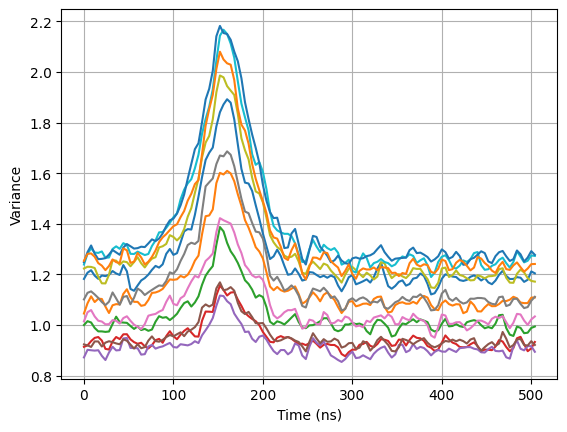

In [159]:
for i in range(12):
    print(f'Index: {3*i}, Angle: {15*i} deg')
    state = data[3*i]
    state_var = state.var(axis=0)/vacuum_var
    plt.plot(t*1e9, state_var, label=f'{15*i} deg')
#plt.plot(t*1e9, temporal_mode, label='Temporal Mode')
#plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

In [162]:
state = data[0]
state.shape

(10000, 127)

In [ ]:
state * temporal_mode

array([[ 2159,   381,  -508, ..., -2032,     0,   762],
       [ 2159,  1905,  1143, ..., -2159, -1651, -1397],
       [ -762, -1270, -2286, ...,  2921,  3302,  3556],
       ...,
       [  889,  1270,   127, ...,     0, -1905, -3429],
       [    0,  -381, -1397, ..., -1778,   127,  1016],
       [    0,   127, -1651, ..., -4953, -3429, -2413]],
      shape=(10000, 127))

In [168]:
temp = np.sum(state*temporal_mode, axis=1)*dt

In [182]:
temp.shape

(10000,)

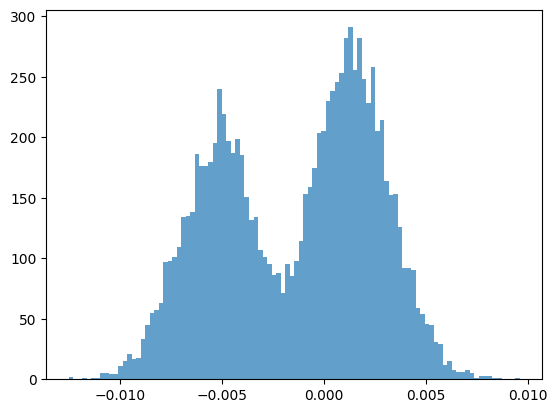

In [172]:
plt.hist(temp, bins=100, density=False, alpha=0.7)
plt.show()

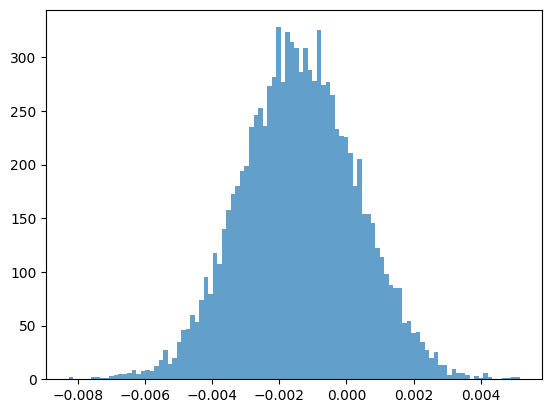

In [176]:
vacuum_quadratures = np.sum(vacuum*temporal_mode, axis=1)*dt
vacuum_mean = np.mean(vacuum_quadratures)
vaccum_std = np.std(vacuum_quadratures)
plt.hist(vacuum_quadratures, bins=100, density=False, alpha=0.7)
plt.show()

Index: 0, Angle: 0 deg
Index: 3, Angle: 15 deg
Index: 6, Angle: 30 deg
Index: 9, Angle: 45 deg
Index: 12, Angle: 60 deg
Index: 15, Angle: 75 deg
Index: 18, Angle: 90 deg
Index: 21, Angle: 105 deg
Index: 24, Angle: 120 deg
Index: 27, Angle: 135 deg
Index: 30, Angle: 150 deg
Index: 33, Angle: 165 deg


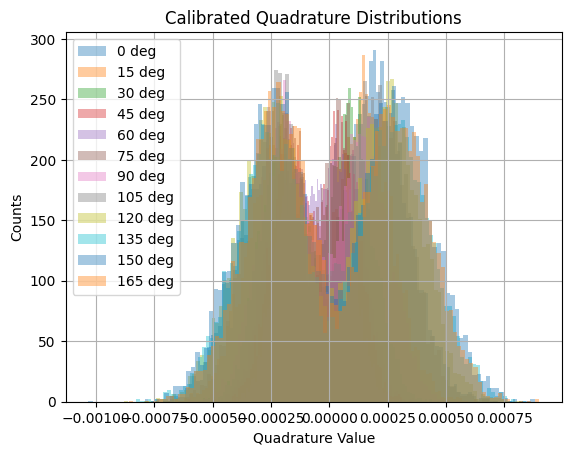

In [180]:
x_values = np.array([])
theta_values = np.array([])

for i in range(12):
    print(f'Index: {3*i}, Angle: {15*i} deg')
    state = data[3*i]
    # Project each trace onto the temporal mode
    quadratures = np.sum(state*temporal_mode, axis=1)*dt
    quadratures = (quadratures - vacuum_mean) / vacuum_std
    x_values = np.append(x_values, quadratures)
    theta_values = np.append(theta_values, np.full_like(quadratures, 15*i))
    theta_values = np.deg2rad(theta_values)
    plt.hist(quadratures, bins=100, density=False, alpha=0.4, label=f'{15*i} deg')
plt.legend()
plt.title("Calibrated Quadrature Distributions")
plt.xlabel("Quadrature Value")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

In [255]:
x_values

array([-2.58508533, -3.34424963, -1.30890396, ...,  2.10406312,
       -1.22382521, -1.23691425], shape=(120000,))

In [220]:
theta_values

array([0.        , 0.        , 0.        , ..., 2.87979327, 2.87979327,
       2.87979327], shape=(120000,))

In [256]:
data = np.column_stack((x_values, theta_values))
data

array([[-2.58508533,  0.        ],
       [-3.34424963,  0.        ],
       [-1.30890396,  0.        ],
       ...,
       [ 2.10406312,  2.87979327],
       [-1.22382521,  2.87979327],
       [-1.23691425,  2.87979327]], shape=(120000, 2))

In [257]:
import numpy as np
from scipy.special import hermite, factorial
from numpy import sqrt, pi, exp
import qutip as qt
import numpy as np
from tqdm import tqdm

def quadrature_povm(x, theta, N):
    """
    Returns the POVM operator Pi(x, theta) = |x_theta><x_theta|
    projected into Fock basis up to N levels.
    """
    # Compute coefficients ⟨n | x_theta⟩ in Fock basis
    coeffs = np.zeros(N, dtype=np.complex128)
    norm = (1 / (pi**0.25)) * exp(-x**2 / 2)

    for n in range(N):
        Hn = hermite(n)(x)
        coeffs[n] = norm * Hn / sqrt(2**n * factorial(n)) * np.exp(-1j * n * theta)

    # Construct |x_theta⟩ as a Qobj ket
    ket = qt.Qobj(coeffs, dims=[[N], [1]])

    # Return projector |x_theta⟩⟨x_theta|
    return ket.proj()
def bin_homodyne_data(x_values, theta_values, num_bins=100, x_range=(-5, 5)):
    """
    Bins the homodyne data per angle.
    
    Returns:
        binned_x: array of bin centers
        binned_theta: corresponding phase for each bin
        binned_counts: count in each bin
    """
    binned_x = []
    binned_theta = []
    binned_counts = []

    thetas_unique = np.unique(theta_values)

    for theta in thetas_unique:
        x_theta = x_values[theta_values == theta]

        counts, edges = np.histogram(x_theta, bins=num_bins, range=x_range)
        bin_centers = (edges[:-1] + edges[1:]) / 2

        binned_x.extend(bin_centers)
        binned_theta.extend([theta] * len(bin_centers))
        binned_counts.extend(counts)

    return np.array(binned_x), np.array(binned_theta), np.array(binned_counts)


In [258]:
def mle_reconstruction_binned(x_bins, theta_bins, counts, N=10, max_iters=20):
    rho = qt.qeye(N) / N  # initial guess

    for it in tqdm(range(max_iters)):
        R = 0
        for x, theta, c in zip(x_bins, theta_bins, counts):
            if c == 0:
                continue
            Pi = quadrature_povm(x, theta, N)
            p = (rho * Pi).tr().real + 1e-12
            R += c * (Pi / p)

        rho_new = R * rho * R
        rho_new = rho_new / rho_new.tr()

        delta = (rho_new - rho).norm()
        rho = rho_new

        if delta < 1e-6:
            print(f"Converged at iteration {it}")
            break

    return rho


In [259]:
# Bin your data
x_bins, theta_bins, counts = bin_homodyne_data(x_values, theta_values, num_bins=200)

# Run MLE
rho_est = mle_reconstruction_binned(x_bins, theta_bins, counts, N=10, max_iters=100)


100%|██████████| 100/100 [05:11<00:00,  3.11s/it]


In [260]:
rho_est

Quantum object: dims=[[10], [10]], shape=(10, 10), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.46805218e-03+4.12561214e-19j -8.06890295e-03-3.49706529e-03j
   4.19117430e-03+7.12896531e-03j  2.57443269e-03-5.36486927e-03j
  -4.48438722e-03-3.81250107e-04j  9.99615037e-04+3.11264109e-03j
   1.57742357e-03-1.46552678e-03j -1.16536613e-03-1.27076021e-04j
   3.83957254e-04+4.67279092e-04j  1.15734520e-05-4.14416163e-04j]
 [-8.06890295e-03+3.49706529e-03j  1.68944232e-02+4.59791533e-19j
  -1.67120646e-02-1.07526742e-02j  3.58567962e-03+1.61264498e-02j
   8.77662902e-03-7.57968441e-03j -7.60116922e-03-4.35237953e-03j
  -8.51802270e-04+6.73500847e-03j  4.29677382e-03-1.33389366e-03j
  -1.46336888e-03-2.39412984e-03j -6.42839504e-04+1.18739992e-03j]
 [ 4.19117430e-03-7.12896531e-03j -1.67120646e-02+1.07526742e-02j
   3.11820156e-02+3.62740168e-18j -2.63400707e-02-2.16546508e-02j
  -6.87944886e-04+2.78773297e-02j  1.97071101e-02-7.22666717e-03j
  -1.06788989e-02-1.38434460e-02j -6.61

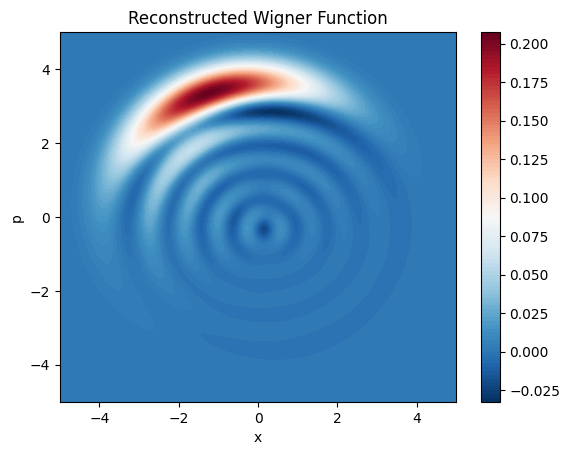

In [261]:
# Plot Wigner function
xvec = np.linspace(-5, 5, 200)
W = qt.wigner(rho_est, xvec, xvec)

import matplotlib.pyplot as plt
plt.contourf(xvec, xvec, W, 100, cmap='RdBu_r')
plt.colorbar()
plt.title("Reconstructed Wigner Function")
plt.xlabel("x")
plt.ylabel("p")
plt.show()

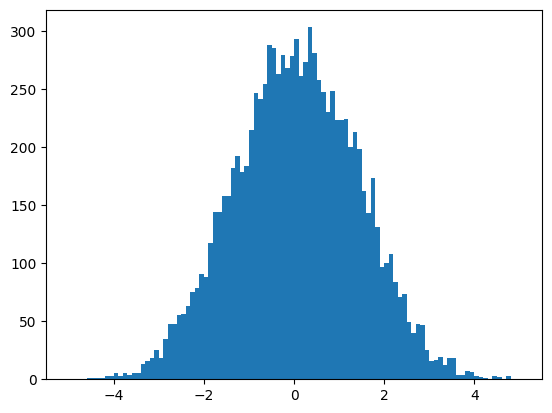

In [217]:
counts, bins = np.histogram(quadratures, bins=100, range=(-5, 5))
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qutip import *

# --- Settings ---
N = 20  # Fock basis cutoff
num_bins = 100  # bins per angle
x_range = (-5, 5)  # quadrature domain
#angles_deg = [0, 30, 60, 90, 120, 150]
#angles_rad = np.deg2rad(angles_deg)

# --- Data ---
data_x = x_values
data_theta = theta_values

# --- Step 1: Bin data and compute histogram per angle ---
binned_data = {}
bin_centers = np.linspace(x_range[0], x_range[1], num_bins)
bin_width = bin_centers[1] - bin_centers[0]

for theta in np.unique(data_theta):
    x_theta = data_x[data_theta == theta]
    hist, _ = np.histogram(x_theta, bins=num_bins, range=x_range)
    binned_data[theta] = hist

# --- Step 2: Precompute eigenstates of x_theta operator ---
projectors = {}     # theta → list of projectors
eigval_tables = {}  # theta → eigenvalues

for theta in np.unique(data_theta):
    a = destroy(N)
    q = (a + a.dag()) / np.sqrt(2)
    p = -1j * (a - a.dag()) / np.sqrt(2)
    x_op = q * np.cos(theta) + p * np.sin(theta)
    eigvals, eigkets = x_op.eigenstates()

    projectors[theta] = [ket * ket.dag() for ket in eigkets]
    eigval_tables[theta] = np.array(eigvals)

# --- Step 3: Utility to get closest projector for a bin center ---
def get_projector(x, theta):
    eigvals = eigval_tables[theta]
    idx = np.argmin(np.abs(eigvals - x))
    return projectors[theta][idx]

# --- Step 4: Parametrize density matrix using Cholesky decomposition ---
def build_rho(params, N):
    # Split real and imaginary parts
    real = params[:N*N].reshape((N, N))
    imag = params[N*N:].reshape((N, N))
    L = Qobj(real + 1j * imag)
    rho = (L.dag() * L).unit()
    return rho

# --- Step 5: Negative log-likelihood with binned data ---
def neg_log_likelihood(params, bin_centers, binned_data, N):
    rho = build_rho(params, N)
    logL = 0
    for theta, hist in binned_data.items():
        for count, x in zip(hist, bin_centers):
            if count == 0:
                continue
            Pi = get_projector(x, theta)
            p = (rho * Pi).tr().real
            p = max(p, 1e-12)
            logL += count * np.log(p)
    return -logL

# --- Step 6: Initial guess ---
L0 = np.eye(N, dtype=complex)
params0 = np.concatenate([L0.real.flatten(), L0.imag.flatten()])

# --- Step 7: Optimize ---
print("Starting optimization...")
result = minimize(
    neg_log_likelihood,
    params0,
    args=(bin_centers, binned_data, N),
    method='BFGS',
    options={'maxiter': 200, 'disp': True}
)

# --- Step 8: Reconstruct density matrix ---
rho_mle = build_rho(result.x, N)


Starting optimization...


KeyboardInterrupt: 

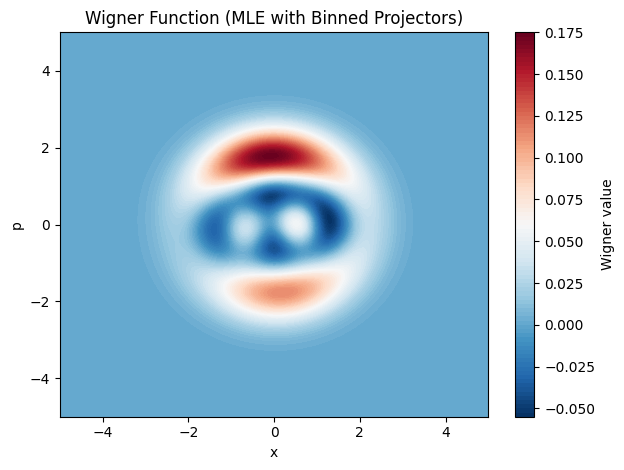

In [177]:
# --- Step 9: Plot Wigner function ---
xvec = np.linspace(-5, 5, 200)
W = wigner(rho_mle, xvec, xvec)

plt.contourf(xvec, xvec, W, 100, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Wigner Function (MLE with Binned Projectors)')
plt.colorbar(label='Wigner value')
plt.tight_layout()
plt.show()

In [90]:
# Project each trace onto the temporal mode
quadratures = np.dot(state, temporal_mode)
quadratures.shape

(10000,)

In [91]:
vacuum_proj = np.dot(vacuum, temporal_mode)
vacuum_mean = np.mean(vacuum_proj)
vacuum_std = np.std(vacuum_proj)

# Calibrated signal
quadratures_calibrated = (quadratures - vacuum_mean) / vacuum_std


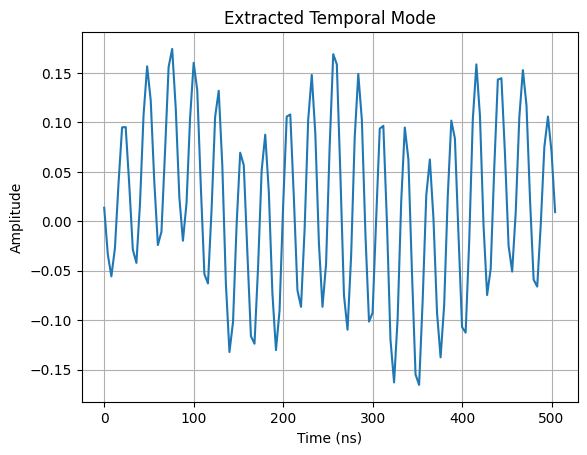

In [92]:
import matplotlib.pyplot as plt

plt.plot(t*1e9, temporal_mode)
plt.title("Extracted Temporal Mode")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


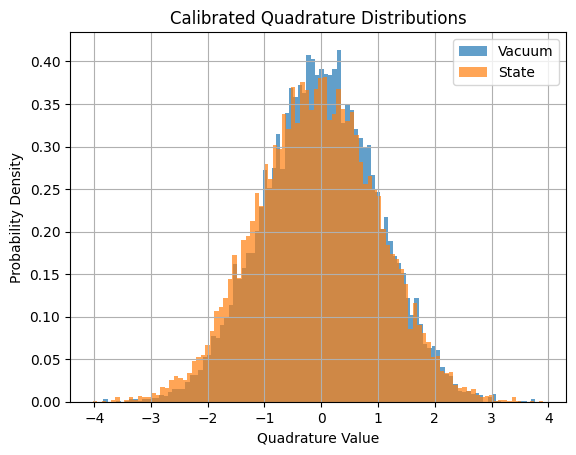

In [97]:
plt.hist((vacuum_proj - vacuum_mean) / vacuum_std, bins=100, density=True, alpha=0.7, label='Vacuum')
plt.hist(quadratures_calibrated, bins=100, density=True, alpha=0.7, label='State')
plt.legend()
plt.title("Calibrated Quadrature Distributions")
plt.xlabel("Quadrature Value")
plt.ylabel("Probability Density")
plt.grid(True)
plt.show()


(0.0, 50000000.0)

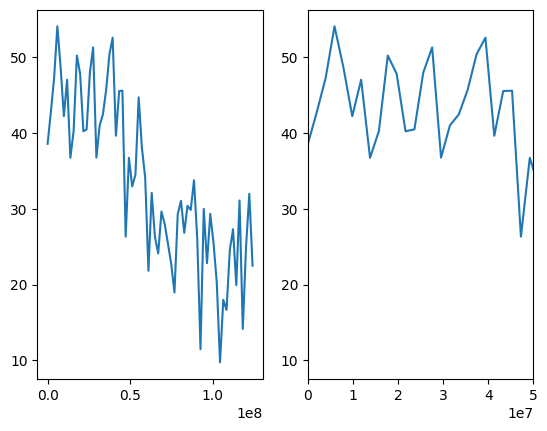

In [66]:
fig, axs = plt.subplots(1, 2)
spec = np.fft.rfft(tora1[0,0,0])
psd = 10*np.log10(np.abs(spec)**2)
axs[0].plot(f, psd)
axs[1].plot(f, psd)
axs[1].set_xlim(0, 50e6)

In [56]:
data

array([[[[-11, -11,  -7, ...,  27,  32,  28],
         [ 10, -10, -22, ...,  18,  21,   9],
         [ 15,  11,  10, ...,   4,  -2,  -8],
         ...,
         [ -8,  -9, -10, ..., -20, -13,  -6],
         [  7,  -9, -19, ...,  -1,  14,  26],
         [-10,  -1,   8, ...,  27,  23,  16]],

        [[  1,  -3,   3, ...,  -8,  -4,  13],
         [ -4, -26, -26, ...,   4,  -5, -15],
         [  4,  21,  16, ...,  -9,  -8, -10],
         ...,
         [-22, -24, -10, ..., -17, -21, -17],
         [-21, -21, -21, ...,  -1,   2,   3],
         [-15,  -9,  -3, ..., -23, -22, -16]],

        [[ -1,  -6,  -9, ...,  16,   9,   1],
         [ 11,  15,  12, ...,  25,  23,  16],
         [  8,  19,  21, ..., -14, -19, -13],
         ...,
         [ 21,   8,  -1, ...,  15,  18,  19],
         [-29, -33, -36, ...,  -3,  12,  17],
         [ 10,  -5, -15, ...,   4,  16,  19]],

        ...,

        [[ -4,  19,  29, ..., -12,  -7, -15],
         [  4,   8,  -5, ...,   5,   9,  14],
         [  7, -12

In [55]:
cat1.shape

(3, 39, 10000, 127)

In [25]:
datasets = [f'cat{i}' for i in range(1, 3)] + [f'tora{i}' for i in range(1, 27)]
datasets

['cat1',
 'cat2',
 'tora1',
 'tora2',
 'tora3',
 'tora4',
 'tora5',
 'tora6',
 'tora7',
 'tora8',
 'tora9',
 'tora10',
 'tora11',
 'tora12',
 'tora13',
 'tora14',
 'tora15',
 'tora16',
 'tora17',
 'tora18',
 'tora19',
 'tora20',
 'tora21',
 'tora22',
 'tora23',
 'tora24',
 'tora25',
 'tora26']

In [28]:
def get_file_list(date, dataset):
    folder = os.path.join(data_folder, date, dataset)
    fns = sorted(os.listdir(folder))
    fns = [os.path.join(folder, fn) for fn in fns]
    return fns

files = {ds:{dat:get_file_list(dat, ds) for dat in dates} for ds in datasets}

FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'C:\\Users\\tbrav\\OneDrive\\Skrivebord\\data-tora\\091028\\cat2'